<a href="https://colab.research.google.com/github/DavidSenseman/BIO1173/blob/main/Class_06_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------
**COPYRIGHT NOTICE:** This Jupyterlab Notebook is a Derivative work of [Jeff Heaton](https://github.com/jeffheaton) licensed under the Apache License, Version 2.0 (the "License"); You may not use this file except in compliance with the License. You may obtain a copy of the License at

> [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

------------------------

# **BIO 1173: Intro Computational Biology**

**Module 6: Convolutional Neural Networks (CNN) for Computer Vision**

* Instructor: [David Senseman](mailto:David.Senseman@utsa.edu), [Department of Integrative Biology](https://sciences.utsa.edu/integrative-biology/), [UTSA](https://www.utsa.edu/)

### Module 6 Material

* **Part 6.1: Using Convolutional Neural Networks**
* Part 6.2: Using Pretrained Neural Networks with Keras
* Part 6.3: Looking at Keras Generators and Image Augmentation


### Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.
  Running the following code will map your GDrive to ```/content/drive```.

In [1]:
# YOU MUST RUN THIS CELL FIRST

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    from google.colab import auth
    auth.authenticate_user()
    COLAB = True
    print("Note: using Google CoLab")
    #%tensorflow_version 2.x
    #print(f"Tensorflow version: {tf.__version__}")
    import requests
    gcloud_token = !gcloud auth print-access-token
    gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
    print(gcloud_tokeninfo['email'])
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab
david.senseman@gmail.com


In [2]:
import tensorflow as tf

print(f"Tensorflow version: {tf.__version__}")

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f'GPU: {gpu}')
else:
    print('No GPU found')

# Check for TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'TPU: {tpu.master()}')
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
except ValueError:
    print('No TPU found')


Tensorflow version: 2.17.0
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
No TPU found


In [3]:
# Record your current Runtime GPU/TPU


# List of Current GPU/TPUs
my_GPU_dict = {
    1: 'CPU',
    2: 'A100',
    3: 'L4 GPU',
    4: 'T4 GPU',
    5: 'TPU v2-8'
}

# Enter the correct key number in the square brackets [ ]
my_GPU = my_GPU_dict[2]

# Print selection
print(f"My current Runtime GPU/TPU is: {my_GPU}")

My current Runtime GPU/TPU is: A100


### Define functions

The cell below creates the function(s) needed for this lesson. You need to run the next cell so your neural network code will work correctly.

In [ ]:
# DON'T FORGET TO RUN THIS FUNCTION

# Simple function to print out elasped time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Part 6.1: Keras Neural Networks for Digits and Medical MNIST

This module will focus on computer vision. There are some important differences and similarities with previous neural networks.

* We will usually use classification, though regression is still an option.
* The input to the neural network is now 3D (height, width, _and_ color)
* Data are not transformed; no more Z-scores or dummy variables.
* Processing time is **_much_** longer.
* We now have different layer types. Besides dense layers, we now have convolution layers, and max-pooling layers.
* Data will no longer arrive as tabular data stored in CSV files, but as hundred or even thousands of **_images_**. We will take advantage of TensorFlow utilities for "flowing" images from folders directly to the input for a neural network.


## Common Computer Vision Data Sets

There are many data sets for computer vision. Two of the most popular classic datasets are the MNIST digits data set and the CIFAR image data sets. We will not use either of these datasets in this lesson, but it is important to be familiar with them since, neural network texts often refer to them.

The [MNIST Digits Data Set](http://yann.lecun.com/exdb/mnist/) is very popular in the neural network research community. You can see a sample of it in Figure 6.MNIST.

**Figure 6.MNIST: MNIST Data Set**
![MNIST Data Set](https://biologicslab.co/BIO1173/images/class_8_mnist.png "MNIST Data Set")

The MNIST Digit Data Set is a large database of handwritten digits that is commonly used for training various image processing systems. It was created by Yan LeCun, Corinna Cortes, and Christopher Burges as a benchmark for evaluating machine learning algorithms in the field of computer vision. The dataset was first released in 1998 and consists of 60,000 training images and 10,000 testing images of handwritten digits from 0 to 9.

The MNIST dataset has been widely used in the research community to develop and test classification algorithms, particularly in the field of deep learning. It has become a standard benchmark for evaluating the performance of machine learning models on image recognition tasks. Despite its simplicity, the MNIST dataset remains popular due to its ease of use and ability to quickly assess the effectiveness of new algorithms.

Over the years, the MNIST dataset has been used in numerous research studies and competitions, leading to the development of more advanced techniques in computer vision. It continues to be a valuable resource for researchers and practitioners in the field of machine learning.

[MedMINST Data Sets](https://medmnist.com/) are a collection of 18 standardized biomedical datasets produced by a consortium of researchers at Harvard University and colaborators in Germany and China. The image sets cover a variety medical tissues and cell types including Chest X-Rays, Colon Pathology, Breast Ultrasound, Blood Cytology and Abdominal CT scans. The `RetinaMINST` dataset has 1,600 fundus camera samples (1,080 training, 120 validation, 400 test).

**Figure 6.MedMNIST: RetinaMNIST Data Set**
![RetinaMNIST](https://biologicslab.co/BIO1173/images/class_06/RetinaMNIST.jpg "RetinaMNIST")

The [CIFAR-10 and CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) datasets are also frequently used by the neural network research community.

**Figure 6.CIFAR: CIFAR Data Set**
![CIFAR Data Set](https://biologicslab.co/BIO1173/images/class_8_cifar.png "CIFAR Data Set")

The CIFAR-10 data set contains low-rez images that are divided into 10 classes. The CIFAR-100 data set contains 100 classes in a hierarchy.

# **Convolutional Neural Networks (CNNs)**

The convolutional neural network (CNN) is a neural network technology that has profoundly impacted the area of computer vision (CV). Fukushima  (1980) [[Cite:fukushima1980neocognitron]](https://www.rctn.org/bruno/public/papers/Fukushima1980.pdf) introduced the original concept of a convolutional neural network, and   LeCun, Bottou, Bengio & Haffner (1998) [[Cite:lecun1995convolutional]](http://yann.lecun.com/exdb/publis/pdf/lecun-bengio-95a.pdf) greatly improved this work. From this research, Yan LeCun introduced the famous LeNet-5 neural network architecture. This chapter follows the **_LeNet-5 style_** of convolutional neural network. Although computer vision primarily uses CNNs, this technology has some applications outside of the field. You need to realize that if you want to utilize CNNs on non-visual data, you must find a way to encode your data to mimic the properties of visual data.  

The order of the input array elements is _crucial_ to the training. In contrast, most neural networks that are not CNNs, treat their input data as a long vector of values. The order in which you arrange the incoming features in this vector is irrelevant. Importantly, you **can't** change the order of the data in these vectors for these types of neural networks once your network has been trained.

On the other hand, the CNN network arranges the inputs into a **_grid_**. This arrangement works well with images because the pixels in closer proximity to each other are important to each other. The order of pixels in an image is significant. The human body is a relevant example of this type of order. For the design of the face, we are accustomed to eyes being near to each other.

This advance in CNNs is due to years of research on biological eyes. In other words, CNNs utilize overlapping fields of input to simulate features of biological eyes. Until this breakthrough, AI had been unable to reproduce the capabilities of biological vision.

Scale, rotation, and noise have presented challenges for AI computer vision research. You can observe the complexity of biological eyes in the example that follows.

A friend raises a sheet of paper with a large number written on it. As your friend moves nearer to you, the number is still identifiable. In the same way, you can still identify the number when your friend rotates the paper. Lastly, your friend creates noise by drawing lines on the page, but you can still identify the number.

As you can see, these examples demonstrate the high function of the biological eye and allow you to understand better the research breakthrough of CNNs. That is, this neural network can process scale, rotation, and noise in the field of computer vision. You can see this network structure in Figure 6.LENET.

**Figure 6.LENET: A LeNET-5 Network (LeCun, 1998)**
![A LeNET-5 Network](https://biologicslab.co/BIO1173/images/class_8_lenet5.png "A LeNET-5 Network")

So far, we have only seen one layer type (dense layers). By the end of this course you will also know about:
  
* **Convolution Layers** - Used to scan across images.
* **Max Pooling Layers** - Used to downsample images.
* **Dropout Layers** - Used to add regularization.
* **LSTM and Transformer Layers** - Used for time series data.


## **Convolution Layers**

The first layer that we will examine is the convolutional layer. We will begin by looking at the hyper-parameters that you must specify for a convolutional layer in most neural network frameworks that support the CNN:

* Number of filters
* Filter Size
* Stride
* Padding
* Activation Function/Non-Linearity

The primary purpose of a convolutional layer is to detect features such as edges, lines, blobs of color, and other visual elements. The filters can detect these features. The more filters we give to a convolutional layer, the more features it can see.

A filter is a square-shaped object that scans over the image. A grid can represent the individual pixels of a grid. You can think of the convolutional layer as a smaller grid that sweeps left to right over each image row. There is also a hyperparameter that specifies both the width and height of the square-shaped filter. The following figure shows this configuration in which you see the six convolutional filters sweeping over the image grid:

A convolutional layer has weights between it and the previous layer or image grid. Each pixel on each convolutional layer is a weight. Therefore, the number of weights between a convolutional layer and its predecessor layer or image field is the following:

```
[FilterSize] * [FilterSize] * [# of Filters]
```

For example, if the filter size were 5 (5x5) for 10 filters, there would be 250 weights.

You need to understand how the convolutional filters sweep across the previous layer's output or image grid. Figure 6.CNN illustrates the sweep:

**Figure 6.CNN: Convolutional Neural Network**
![Convolutional Neural Network](https://biologicslab.co/BIO1173/images/class_8_cnn_grid.png "Convolutional Neural Network")

The above figure shows a convolutional filter with 4 and a padding size of 1. The **_padding size_** is responsible for the border of zeros in the area that the filter sweeps. Even though the image is 8x7, the extra padding provides a virtual image size of 9x8 for the filter to sweep across. The **_stride_** specifies the number of positions the convolutional filters will stop. The convolutional filters move to the right, advancing by the number of cells specified in the stride. Once you reach the far right, the convolutional filter moves back to the far left; then, it moves down by the stride amount and continues to the right again.

Some constraints exist concerning the size of the stride. The stride cannot be `0`. The convolutional filter would never move if you set the stride to `0`. Furthermore, neither the stride nor the convolutional filter size can be larger than the previous grid. There are additional constraints on the stride (*s*), padding (*p*), and the filter width (*f*) for an image of width (*w*). Specifically, the convolutional filter must be able to start at the far left or top border, move a certain number of strides, and land on the far right or bottom border. The following equation shows the number of steps a convolutional operator
must take to cross the image:

$$ steps = \frac{w - f + 2p}{s}+1 $$

The number of steps must be an integer. In other words, it cannot have decimal places. The purpose of the padding (*p*) is to be adjusted to make this equation become an integer value.


## **Max Pooling Layers**

Max-pool layers downsample a 3D box to a new one with smaller dimensions. Typically, you can always place a max-pool layer immediately following the convolutional layer. The LENET shows the max-pool layer immediately after layers C1 and C3. These max-pool layers progressively decrease the size of the dimensions of the 3D boxes passing through them. This technique can avoid overfitting (Krizhevsky, Sutskever & Hinton, 2012).

A pooling layer has the following hyper-parameters:

* Spatial Extent (*f*)
* Stride (*s*)

Unlike convolutional layers, max-pool layers do not use padding. Additionally, max-pool layers have no weights, so training does not affect them. These layers downsample their 3D box input. The 3D box output by a max-pool layer will have a width equal to this equation:

$$ w_2 = \frac{w_1 - f}{s} + 1 $$

The height of the 3D box produced by the max-pool layer is calculated similarly with this equation:

$$ h_2 = \frac{h_1 - f}{s} + 1 $$

The depth of the 3D box produced by the max-pool layer is equal to the depth the 3D box received as input. The most common setting for the hyper-parameters of a max-pool layer is f=2 and s=2. The spatial extent (f) specifies that boxes of 2x2 will be scaled down to single pixels. Of these four pixels, the pixel with the maximum value will represent the 2x2 pixel in the new grid. Because squares of size 4 are replaced with size 1, 75% of the pixel information is lost. The following figure shows this transformation as a 6x6 grid becomes a 3x3:

**Figure 6.MAXPOOL: Max Pooling Layer**
![Max Pooling Layer](https://biologicslab.co/BIO1173/images/class_8_conv_maxpool.png "Max Pooling Layer")

Of course, the above diagram shows each pixel as a single number. A grayscale image would have this characteristic. We usually take the average of the three numbers for an RGB image to determine which pixel has the maximum value.

----------------------------------------
### **Supervised _vs_ Unsupervised Machine Learning**

In **_supervised machine learning_**, the algorithm is trained on a _labeled_ dataset, where each training example is paired with the correct output. The goal is to learn a mapping from input features to the corresponding output labels. During training, the algorithm adjusts its parameters to minimize the difference between the predicted output and the true label. Once the model is trained, it can make predictions on new, unseen data by applying the learned mapping. Common supervised learning tasks include classification and regression.

On the other hand, **_unsupervised machine learning_** involves training the algorithm on an _unlabeled_ dataset, where the algorithm must find patterns or relationships in the data without explicit guidance. The goal of unsupervised learning is to discover hidden structures or clusters in the data. This type of learning is often used for tasks such as clustering, anomaly detection, and dimensionality reduction. Unlike supervised learning, there are no explicit output labels to guide the learning process in unsupervised learning.

---------------------------------------------

## **Regression Convolutional Neural Networks**

We will now look at two examples, one for regression and another for classification. For _supervised_ computer vision, your dataset will need some labels. For classification, this label usually specifies _what_ the image is a picture of, e.g., dog, cat, carcinoma, etc. For regression, this "label" is some _numeric_ quantity the image should produce, such as a count, e.g. how many white blood cells. We will look at two different means of providing this label.

The first example will show how to handle regression with convolution neural networks. We will provide an image and expect the neural network to count items in that image. We will use the `crowd_counting` dataset that contains images taken at a mall with different number of shoppers.

Here are three sample images from the 2,000 images in the `crowd_counting` dataset:

![Crowd Counting Sample](https://biologicslab.co/BIO1173/images/crowd_counting_images_small.png "Crowd Counting Sample")

Each image is 480X640 pixels with 3 color channels (RGB).

Our goal will be to create a convolutional neural network (CNN) that can _count_ the number of people in an image. To put in a more ecological or biomedical context, a similar neural network could also be trained to count the number of giant Saguaro cacti (_Carnegiea gigantea_) in an image of the Sonoran Desert, or the number of leucocytes in a blood smear from a patient with symptoms of AML (Acute myeloid leukemia).  


In [4]:
# Create functions for this lesson

import tensorflow as tf
import psutil

def check_runtime_hardware():
    # Check for GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            print(f'GPU: {gpu}')
    else:
        print('No GPU found')

    # Check for TPU
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print(f'TPU: {tpu.master()}')
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
    except ValueError:
        print('No TPU found')

def check_current_ram():
  ram = psutil.virtual_memory()
  print(f"Available RAM: {ram.available / (1024 ** 3):.2f} GB")

# Simple function to print out elasped time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


In [ ]:
# Initial system check

check_runtime_hardware()
check_current_ram()

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
No TPU found
Available RAM: 80.71 GB


### **Step - 1: Setup Evironmental Variables**

**_Environmental variables_** are like hidden settings that tell your computer how to behave. They hold information that can affect how programs run on your system, such as paths to files, system directories, or user-specific settings. It's like setting the stage for your computer to know where to find all its props and scripts.

The code in the cell below creates environmental variables that a needed to download a specific datafile and where the data should be stored.

In [1]:
# Setup Environmental Variables

import os

# Define datafile location
URL = "https://biologicslab.co/BIO1173/data"
DOWNLOAD_SOURCE = URL+"/OcularDisease.zip"
DOWNLOAD_NAME = DOWNLOAD_SOURCE[DOWNLOAD_SOURCE.rfind('/')+1:]
print(f"DOWNLOAD_SOURCE {DOWNLOAD_SOURCE}")
print(f"DOWNLOAD_NAME {DOWNLOAD_NAME}")

# Define folder locations to store the data
PATH = "/content"
EXTRACT_TARGET = os.path.join(PATH,"OcularDisease")
#SOURCE = os.path.join(EXTRACT_TARGET, "OcularDisease")
SOURCE = EXTRACT_TARGET # In this case its the same, no subfolder
print(f"PATH {PATH}")
print(f"EXTRACT_TARGET {EXTRACT_TARGET}")
print(f"SOURCE {SOURCE}")


DOWNLOAD_SOURCE https://biologicslab.co/BIO1173/data/OcularDisease.zip
DOWNLOAD_NAME OcularDisease.zip
PATH /content
EXTRACT_TARGET /content/OcularDisease
SOURCE /content/OcularDisease


In [1]:
# Step - 1: Setup Environmental Variables

import os

# Define datafile location
URL = "https://biologicslab.co/BIO1173/data"
DOWNLOAD_SOURCE = URL+"/bloodmnist_224.npz"
DOWNLOAD_NAME = DOWNLOAD_SOURCE[DOWNLOAD_SOURCE.rfind('/')+1:]
print(f"DOWNLOAD_SOURCE {DOWNLOAD_SOURCE}")
print(f"DOWNLOAD_NAME {DOWNLOAD_NAME}")

# Define folder locations to store the data
PATH = "/content"
print(f"PATH {PATH}")
EXTRACT_TARGET = os.path.join(PATH,"blood_mnist_224.npz")
SOURCE = os.path.join(EXTRACT_TARGET)             # "crowd_counting")
print(f"EXTRACT_TARGET {EXTRACT_TARGET}")
print(f"SOURCE {SOURCE}")


DOWNLOAD_SOURCE https://biologicslab.co/BIO1173/data/bloodmnist_224.npz
DOWNLOAD_NAME bloodmnist_224.npz
PATH /content
EXTRACT_TARGET /content/blood_mnist_224.npz
SOURCE /content/blood_mnist_224.npz


If the code is correct, you should see the following output:

~~~text
DOWNLOAD_SOURCE https://biologicslab.co/BIO1173/data/crowd_counting.zip
DOWNLOAD_NAME crowd_counting.zip
PATH /content
EXTRACT_TARGET /content/crowd_counting
SOURCE /content/crowd_counting
~~~

We are going to download a datafile called `crowd_counting.zip` from the course file server. When we extract (unzip) this datafile its contents will be stored in the folder called `/content/crowd_counting`,

### **Step - 2: Download the Data and Extract It**

In Step 1 we defined what file we wanted to download and the folder to place the data after we unzipped the file. In the next cell we perform the download and the extraction.

#### **Download File**

The code in the cell below uses this code chunk to download the datafile.
~~~text
!wget -O {os.path.join(PATH,DOWNLOAD_NAME)} {DOWNLOAD_SOURCE}
~~~

The program `wget` is a non-interactive network downloader commonly used in Unix-like operating systems. It retrieves files from the web using HTTP, HTTPS, and FTP protocols.

#### **Extract File Contents**

The datafile is compressed (i.e. a `zip file`), so we need to extract the file contents. The next code chunk unzips it to folder specified by the environmental variables defined above:
~~~text
!unzip -o -d {EXTRACT_TARGET} {os.path.join(PATH, DOWNLOAD_NAME)} >/dev/null
~~~
The command `unzip` is a command-line utility used to extract files from a ZIP archive.

At the end of the `unzip` command is `>/dev/null`. Normally, the `unzip` command prints out the name of every file that was extracted. Since there are 2,000 images, we don't want to see this print out. Instead the output is sent instead to `> dev/null` which hids the output. `dev/null` a special file that discards all data written to it—like a black hole for unnecessary or unwanted output. If you send a program’s output to /dev/null, it's basically saying, "I don't need this, just throw it away."

In [ ]:
# Step - 2: Download datafile and extract it

print("Downloading files...")
!wget -O {os.path.join(PATH,DOWNLOAD_NAME)} {DOWNLOAD_SOURCE}
!mkdir -p {SOURCE}
!mkdir -p {TARGET}
!mkdir -p {EXTRACT_TARGET}
#print(f"Extracting files...", end=' ')
#!unzip -o -d {EXTRACT_TARGET} {os.path.join(PATH, DOWNLOAD_NAME)} >/dev/null
print("done.")

--2024-10-27 00:54:38--  https://biologicslab.co/BIO1173/data/bloodmnist_224.npz
Resolving biologicslab.co (biologicslab.co)... 194.163.45.209
Connecting to biologicslab.co (biologicslab.co)|194.163.45.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540731655 (1.4G) [application/octet-stream]
Saving to: ‘/content/bloodmnist_224.npz’

          /content/  47%[========>           ] 693.71M  7.20MB/s    eta 84s    

In [8]:
len('blood_mnist_244.npz')

19

In [11]:
import os

# List files in the current directory
files = os.listdir('.')
print(files)


['.config', 'drive', '{TARGET}', 'blood_mnist_224.npz', 'bloodmnist_224.npz', 'sample_data']


In [10]:
import numpy as np

# Load the .npz file
data = np.load('./blood_mnist_224.npz')

# Extract and save each array
for file in data.files:
    np.save(f'{file}.npy', data[file])

# Print the list of extracted files
print(f'Extracted files: {data.files}')


IsADirectoryError: [Errno 21] Is a directory: './blood_mnist_224.npz'

If the code is correct, you should see the following output:

~~~text
Downloading files...
--2024-10-26 20:06:01--  https://biologicslab.co/BIO1173/data/crowd_counting.zip
Resolving biologicslab.co (biologicslab.co)... 194.163.45.209
Connecting to biologicslab.co (biologicslab.co)|194.163.45.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1263707204 (1.2G) [application/zip]
Saving to: ‘/content/crowd_counting.zip’

/content/crowd_coun 100%[===================>]   1.18G  9.03MB/s    in 2m 18s  

2024-10-26 20:08:20 (8.73 MB/s) - ‘/content/crowd_counting.zip’ saved [1263707204/1263707204]

Extracting files... done.
~~~

Image datafiles used by CNN neural networks need to be relatively large which means they take a fair amount of time to download, and then, they require a lot of memory and disk space to store and process. This is one of the main reasons for using Google Colab instead of doing this on your laptop.

### **Step - 3: Get Labels from File**

Since we are going to perform _supervised_  machine learning, our neural network will need to know how many people are in each image. In other words, we need to get the _labels_ for the images. In this example, the label for each image is simply the number of people that can be seen. Since there are 2000 images, there are 2000 labels. You can think of each image and an X-value and its label as the Y-value.

The file containing the labels were downloaded as part of the datafile. When we extracted (unzipped) the datafile, the file containining the labels ("label.cvs") ended up in the folder called `crowd_counting`.

The code in the cell below, uses the pandas `pd.read_csv()` function to read this datafile and create a new DataFrame called `label_df` to hold the labels.

In [12]:
# Step - 3: Get labels from file

import pandas as pd

# Define filename holding the labels
label_fname = "labels.csv"

# Get labels corresponding to the images
label_df = pd.read_csv(os.path.join(SOURCE,label_fname))

# Specify columns
#label_df.columns = ['id' , 'people']

# Print out the first 5 labels
label_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/blood_mnist_224.npz/labels.csv'

If the code is correct, you should see the following table:


![__](https://biologicslab.co/BIO1173/images/class_06/class_06_1_image04.png)

Looking at the output, we can see that the first image contains `35` people, the second image contains `41` people, and so on.

### **Step - 4: Load Images into Numpy Array**

Image data in dataset can be stored in different formats. In many cases, the image data is stored as individual pictures (frames) in a JPEG format or PNG format.

However, in this dataset, the images were stored as a very large Numpy array called `image.npy`. The Numpy `.npy` format is a way to save Numpy arrays to disk in a binary file. This format stores the shape, data type, and data of the array efficiently, allowing for fast reading and writing making it perfect for handling large amounts of numerical data in a compact, easy-to-access way.

Here is the code that reads the file `images.npy` and loads it into a numpy array called `img_ar`:

~~~text
# loading the images in vector format
img_ar = np.load(os.path.join(SOURCE,"images.npy"),)
~~~

To see what the numpy array `img` looks like, we can use the following line of code:

~~~text
# Print image details
img_ar.shape
~~~

In [13]:
import os

# List files in the current directory
files = os.listdir('.')
print(files)


['.config', 'drive', '{TARGET}', 'blood_mnist_224.npz', 'bloodmnist_224.npz', 'sample_data']


In [9]:
# Step - 4: Load images into numpy array

import numpy as np

# Unpack images into numpy array
img_ar = np.load(os.path.join(SOURCE,"bloodmnist_224.npz"),)

# Print image details
img_ar.shape

FileNotFoundError: [Errno 2] No such file or directory: '/content/blood_mnist_224.npz/images.npy'

If the code is correct, you should see:

~~~text
(2000, 480, 640, 3)
~~~

This means that our Numpy array `img_ar` contains `2000` images and each image is 480 x 640 pixels with 3 color channels (RGB).


### **Step - 5: Load Labels into Numpy Array**

In general, neural networks are designed to work with data in Numpy arrays, not DataFrames. Since our labels are stored in the DataFrame `label_df`, we need to convert this label information into a Numpy array.

The code in the cell below uses the function `np.array()` to convert the labels in the column `people` into a Numpy array called `labels_ar`.

In [ ]:
# Step - 5: Load labels into numpy array

# load labels
labels_ar = np.array(label_df['people'])

# Print out the array
labels_ar

array([35, 41, 41, ..., 25, 26, 26])

If the code is correct, you should see the following output:
~~~text
array([35, 41, 41, ..., 25, 26, 26])
~~~

As you can see, the numpy array `labels_ar` contains the number of people in each image.

### **Step - 6: Create Train and Test Sets**

Now that we have our "X-values" (i.e. the images) in a Numpy array called `img_ar` and out "Y-values" (i.e. the image labels) in a Numpy array called `label_ar` we are ready to create our X and Y train and test sets.

Here is the code chunk that generates the training and test sets:
~~~text
# Create x and y train/test sets
x_train, x_test, y_train, y_test = train_test_split(img_ar, labels_ar, test_size=0.1)
~~~

The X-values are coming from the Numpy array `img_ar` and the Y-values are coming from the Numpy array called `label_ar`. The argument `test_size=0.1` tells the command to split the data so that 90% of the dataset will be used for training the neural network with the remaining 10% being used to test it.

In [ ]:
# Step - 6: Create train and test sets

from sklearn.model_selection import train_test_split

print(f"Before split:", end=' ')
check_current_ram()
print("")

# Create x and y train/test sets
x_train, x_test, y_train, y_test = train_test_split(img_ar, labels_ar, test_size=0.1)

#train_dataset = train_dataset.repeat()  # Repeats indefinitely

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Print number of images in X-train
print(f"Number of images in x_train: {x_train.shape[0]}")
# Print number of images in X-test
print(f"Number of images in x_test: {x_test.shape[0]}")
print("")

print(f"After split:", end=' ')
check_current_ram()

Before split: Available RAM: 326.50 GB

Number of images in x_train: 1800
Number of images in x_test: 200

After split: Available RAM: 311.02 GB


If the code is correct, you should see the following output:

~~~text
Before split: Available RAM: 46.75 GB

Number of images in x_train: 1800
Number of images in x_test: 200

After split: Available RAM: 31.26 GB
~~~

That sound right. Since there are 2000 images total, 10% would be 200 images for the test set (`x_test`) leaving the remaining 1800 images for the training set (`x_train`).

### **Step - 7: Create and Compile CNN neural network model**

The code in the cell below builds a classic **_Convolutional Neural Network (CNN) model_**.

#### **Create CNN model**

Here is a summary of the model:

1. **Conv2D Layer:** 64 filters, kernel size 3x3, using ReLU activation, input shape is 480x640x3.
2. **MaxPool2D Layer:** Reduces spatial dimensions by a factor of 2.
3. **Conv2D Layer:** 128 filters, kernel size 3x3, using ReLU activation.
4. **MaxPool2D Layer:** Another spatial dimension reduction.
5. **Dropout Layer:** Drops 20% of neurons to prevent overfitting.
6. **Flatten Layer:** Converts the 2D matrix data to a vector.
7. **Dense Layer:** Fully connected layer with 128 neurons, using ReLU activation.
8. **Dense Layer:** Output layer with 1 neuron, using linear activation.

This model is structured for an image regression task since there is only 1 neuron in the output layer.

#### **Model Compiler**

Here is the code used to compile the model:

~~~text
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(learning_rate=1e-6), metrics=['mae'])

~~~
This code is setting up how your model will learn. It’s like telling your model how to play a game and how to keep score:

* **loss=keras.losses.MeanSquaredError():** You're using Mean Squared Error (MSE) as your loss function. MSE measures how well the model's predictions match the actual data, penalizing larger errors more heavily.

* **optimizer=keras.optimizers.Adam(learning_rate=1e-6):** You're using the Adam optimizer to adjust the model's weights. Adam is known for being efficient and well-suited for large datasets or parameters. The learning rate here is set to a very small value (1e-5), controlling how much the model updates its weights with each step.

* **metrics=['mae']:** You're keeping track of Mean Absolute Error (MAE) during training. MAE measures the average magnitude of errors in predictions, without considering their direction.

Essentially, you’re defining how the model should optimize itself and how you’ll measure its performance.


In [ ]:
# Step - 7:Create and Compile CNN model

import pandas as pd
import numpy as np
import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten

# Define variables
input_dim = (480,640,3)

# Create CNN model
model = keras.Sequential([

    keras.layers.Input(shape=input_dim),
    keras.layers.Conv2D(64, (3,3),
          activation=keras.activations.relu),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Conv2D(128, (3,3),
          activation=keras.activations.relu),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128,
          activation=keras.activations.relu),
    keras.layers.Dense(1,
          activation = keras.activations.linear)

])

# Compile model
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(learning_rate=1e-5), metrics=['mae'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 478, 638, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 239, 319, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 237, 317, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 118, 158, 128)     0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 118, 158, 128)     0         
                                                                 
 flatten (Flatten)           (None, 2386432)           0

If the code is correct, you should see the following table:


![__](https://biologicslab.co/BIO1173/images/class_06/class_06_1_image14.png)

### **Step - 8: Create Callback Monitors**

The code in the cell below creates two different **_callback monitors_**. A Keras callback monitor tracks specific metrics or quantities during the training process and allows you to take action based on their values. It's like having a smart assistant that keeps an eye on how well your model is performing. These callbacks help make the training process more efficient and adaptive by reacting to the monitored metrics in real-time.

#### **Keras Learning Rate Scheduler**

The Keras learning rate scheduler dynamically adjusts the learning rate during training based on a predefined schedule or function. This helps the model converge more efficiently by adapting the learning rate as needed.

Here is the code for the learning rate monitor:
~~~text
# Add learning rate monitor
l_rate_monitor = keras.callbacks.LearningRateScheduler(
                lambda epochs : 1e-8 * 10 ** (epochs/20))
~~~

This code snippet creates a learning rate scheduler to adjust the learning rate during training. Here's the breakdown:

* **keras.callbacks.LearningRateScheduler:** This callback adjusts the learning rate according to a given schedule.
* **lambda epochs : (epochs/20):** This is the function that defines how the learning rate changes over epochs. It starts with a very low learning rate (1e-8) and increases it exponentially based on the formula:

$$ 1 \times 10^{-8} \cdot 10^{\frac{\text{epochs}}{20}} $$

In essence, this dynamically adjusts the learning rate to help the model converge more efficiently by starting slow and gradually speeding up as training progresses.

#### **Early Stopping**

Here is the early stopping monitor:

~~~text

# Create early stopping monitor
e_stop_monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10,
                 verbose=1, mode='auto', restore_best_weights=True)
~~~

This snippet is configuring the EarlyStopping callback in Keras, which helps prevent overfitting by stopping the training once the model’s performance stops improving. Here's a breakdown:

* **monitor='val_loss':** Watches the validation loss to decide when to stop training.
* **min_delta=1e-3:** The minimum change in the monitored quantity to qualify as an improvement. In this case, 0.001.
* **patience=10:** Number of epochs with no improvement after which training will be stopped. Here, it's set to 10 epochs.
* **verbose=1:** Provides updates in the console about the training process.
* **mode='auto':** Automatically decides if it should look for an increase or decrease in the monitored metric.
* **restore_best_weights=True:** After stopping, the model will revert to the weights that achieved the best validation loss.

In [ ]:
# Step - 8: Create callback monitors

from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler


# Create learning rate monitor
l_rate_monitor = keras.callbacks.LearningRateScheduler(lambda epochs : 1e-8 * 10 ** (epochs/20))

# Create early stopping monitor
e_stop_monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10,
                 verbose=1, mode='auto', restore_best_weights=True)

If the code ran correctly, no output would be generated.

### **Step - 9: Train the Neural Network**

Training (`model.fit()`) takes the greatest amount of time and computer power. The code in the cell below trains the neural network model on the training data and monitors its performance on the validation data.

The two most important variables that you can change is the maximum number of **_epochs_** to train the model and the **_batch size_**. The code in the cell below is set to train the neural network for a maximum of 100 epochs. This is an upper limit since the training includes an _early stopping monitor_ to stop training if overfitting is detected.

Here's the summary:

* **model.fit(x_train, y_train, ...):** This is the method to train the model.
* **validation_data=(x_test, y_test):** This is the data the model will use to validate its learning after each epoch (one complete pass through the training data).
* **epochs=EPOCHS:** This specifies the number of times the training process will iterate over the entire dataset.
* **batch_size=BATCH_SIZE:** This sets the number of samples that will be propagated through the network at once. Smaller batches mean more updates per epoch but higher computation cost. Your GPU or TPU can limit batch xize; larger batches require more memory. In practice, a batch size of 32, 64, of 128 are good places to start.
* **steps_per_epoch:** A good value for steps_per_epoch depends on the size of your training dataset and batch size. As a rule of thumb, it’s often set to the total number of training samples divided by the batch size:

$$ \text{steps_per_epoch} = \frac{\text{number of training samples}}{\text{batch size}} $$

+ since the number of training samples = 1800 and the batch size is set to 64, the `steps_per_bactch` is set to `28`.

* **callbacks=[e_stop_monitor,lr_monitor]:** This uses a callback function to implement early stopping as well as to monitor and possibly adjust the learning rate during training, helping the model to learn more effectively.

All these elements together help the model learn from the training data, while checking its performance and making adjustments based on the validation data.

### **IMPORTANT NOTICE: How Long Training Will Take Depends on the GPU/TPU**

The types of GPUs and TPUs that are available in Colab vary over time. This is necessary for Colab to be able to provide access to these resources free of charge. When running the next cell using Colab's least powerful GPU/TPU accelerator, the **A100 GPU**, running 100 epochs only required 9 minutes. Howver, when the same code was run using Colab's most powerful accelerator, the **TPU v2.8** co-processor, 100 epochs required over **_7 hours!_**


If your code is correct, you should see something similar to this:

~~~text
My current Runtime GPU/TPU is: L4 GPU
~~~

However, if you see this error:

~~~text
  File "<ipython-input-17-52964824f281>", line 12
    my_GPU = my_GPU_dict[ ]
                          ^
SyntaxError: invalid syntax
~~~
it means you didn't enter your current Runtime GPU/TPU.

In [ ]:
# Step - 8: Train the Model -- This will take at least 45 minutes!

import time
import tensorflow as tf

# Set variables
EPOCHS=10
BATCH_SIZE=32
# STEPS_PER_EPOCH=50

# Record start time
start_time = time.time()

# Print header
print(f"----- Training is starting for {EPOCHS} epochs, batch size:{BATCH_SIZE}, runtime GPU/TPU:{my_GPU} --------------")

# Train the model
history = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          epochs=EPOCHS, batch_size=BATCH_SIZE,
 #         steps_per_epoch=STEPS_PER_EPOCH,
          callbacks=[e_stop_monitor, l_rate_monitor])

# Record end time
elapsed_time = time.time() - start_time

# Print elapsed time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

----- Training is starting for 10 epochs, batch size:32, runtime GPU/TPU:TPU v2-8 --------------
Epoch 1/10
57/57 [==============================] - 276s 5s/step - loss: 1013.4632 - mae: 31.0702 - val_loss: 1031.6981 - val_mae: 31.3436 - lr: 1.0000e-08
Epoch 2/10
57/57 [==============================] - 270s 5s/step - loss: 1002.0778 - mae: 30.8860 - val_loss: 1018.6113 - val_mae: 31.1335 - lr: 1.1220e-08
Epoch 3/10
57/57 [==============================] - 270s 5s/step - loss: 987.4654 - mae: 30.6484 - val_loss: 1002.1231 - val_mae: 30.8664 - lr: 1.2589e-08
Epoch 4/10
57/57 [==============================] - 269s 5s/step - loss: 971.1703 - mae: 30.3805 - val_loss: 985.7687 - val_mae: 30.5994 - lr: 1.4125e-08
Epoch 5/10
57/57 [==============================] - 269s 5s/step - loss: 954.1708 - mae: 30.0980 - val_loss: 967.5795 - val_mae: 30.2997 - lr: 1.5849e-08
Epoch 6/10
57/57 [==============================] - 268s 5s/step - loss: 934.7297 - mae: 29.7718 - val_loss: 947.0065 - val_mae:

~~~text

----- Training is starting for 2 epochs with batch size of 32 and using GPU/TPU: CPU --------------
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 516s 10s/step - loss: 994.6331 - mae: 30.7529 -
Elapsed time: 0:10:23.11
~~~

~~~text
----- Training is starting for 10 epochs, batch size:32, runtime GPU/TPU:A100 --------------
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 277ms/step - loss: 1012.1794 - mae: 31.0448 - val_loss: 1021.3042 - val_mae: 31.1450 - learning_rate: 1.0000e-08

Restoring model weights from the end of the best epoch: 10.
Elapsed time: 0:01:41.34
~~~

~~~text
----- Training is starting for 10 epochs, batch size:32, runtime GPU/TPU:L4 GPU --------------
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 68s 751ms/step - loss: 993.9785 - mae: 30.7550 -
Elapsed time: 0:04:44.87
~~~

~~~text
----- Training is starting for 10 epochs, batch size:32, runtime GPU/TPU:T4 GPU --------------
Epoch 1/10
---------------------------------------------------------------------------
UnknownError                              Traceback (most recent call last)
<ipython-input-12-2bf504cc6e12> in <cell line: 18>()
     16
     17 # Train the model
---> 18 history = model.fit(x_train, y_train,
     19           validation_data=(x_test, y_test),
     20           epochs=EPOCHS, batch_size=BATCH_SIZE,
~~~

~~~text
# Print header
print(f"----- Training is starting for {EPOCHS} epochs, batch size:{BATCH_SIZE}, runtime GPU/TPU:{my_GPU} --------------")

~~~

In the code is correct, you should see something similar to the following output:

~~~text
----- Training is starting for 100 epochs with a batch size of 32 --------------
Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - loss: 649.7441 - mae: 24.5181 - val_loss: 689.9487 - val_mae: 25.2800 - learning_rate: 1.0000e-08
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 645.5746 - mae: 24.4280 - val_loss: 672.4487 - val_mae: 24.9304 - learning_rate: 1.1220e-08
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 616.5085 - mae: 23.8625 - val_loss: 653.2784 - val_mae: 24.5418 - learning_rate: 1.2589e-08
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 605.0363 - mae: 23.6401 - val_loss: 632.1492 - val_mae: 24.1062 - learning_rate: 1.4125e-08
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 590.8585 - mae: 23.2374 - val_loss: 609.1398 - val_mae: 23.6226 - learning_rate: 1.5849e-08
.................................
Epoch 83/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 1.6171 - mae: 0.9261 - val_loss: 5.7220 - val_mae: 1.9087 - learning_rate: 1.2589e-04
Epoch 84/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 2.3572 - mae: 1.2134 - val_loss: 5.4841 - val_mae: 1.8043 - learning_rate: 1.4125e-04
Epoch 85/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.9644 - mae: 0.7490 - val_loss: 5.0645 - val_mae: 1.7056 - learning_rate: 1.5849e-04
Epoch 86/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 1.4262 - mae: 0.9621 - val_loss: 6.4713 - val_mae: 1.8962 - learning_rate: 1.7783e-04
Epoch 87/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 3.7186 - mae: 1.6049 - val_loss: 6.3887 - val_mae: 1.9236 - learning_rate: 1.9953e-04
Epoch 87: early stopping
Restoring model weights from the end of the best epoch: 77.
Elapsed time: 0:09:07.25

~~~

In this particular instance, training was stopped after the 87th epoch with the best weights recorded after the 77th epoch.

The total training time was 9 minutes using Google's A100 GPU/TPU accelerator.

### **Saving and Downloading the Trained Model**

If you want to save your trained model and download it to your home computer you can uncomment the code in the cell below.

In [ ]:
# Saving and downloading the model

from keras.models import save_model
from google.colab import files
import os

# Uncomment the next line to save the model in the native Keras format
#model.save('crowd_regression_model.keras')

# Uncomment the next line to download the saved to your computer
#files.download('crowd_regression_model.keras')

# Print contents of your current Colab director
files = os.listdir('.')
print(files)

['.config', 'drive', 'crowd_counting.zip', '{TARGET}', 'crowd_counting', 'sample_data']


If the code is correct, you should see the following output:

~~~text
['.config', 'drive', 'crowd_counting.zip', '{TARGET}', 'crowd_counting', 'sample_data']
~~~

This is the current file content of your Colab notebook.  

## **Evaluating Model's Training**

Now that we have trained our model, let's look at how the model changed during training.

#### **How Did the Learning Rate Change?**

Run the next cell to print out the maximum and minimum values of the model's learning rate during training. You should note that when training was started (i.e. epoch 1), the rate was set to `learning_rate (1e-8)`.

In [ ]:
print(f"Minimum learning rate: {np.min(history.history['learning_rate'])}")
print(f"Maximum learning rate: {np.max(history.history['learning_rate'])}")
print(f"Minimum loss: {np.min(history.history['loss'])}")

Minimum learning rate: 9.99999993922529e-09
Maximum learning rate: 0.0001995262282434851
Minimum loss: 0.5318541526794434


If the code is correct, you should see the following output:

~~~text
Minimum learning rate: 9.99999993922529e-09
Maximum learning rate: 0.0001995262282434851
Minimum loss: 0.5318541526794434
~~~

The minimum learning rate is essentially `1e-8`.

To compare these two numbers:

$$ 0.0001995262282434851 \text{ and } 9.99999993922529 \times 10^-9$$

We divide the first number by the second:

$$ 0.0001995262282434851 \div \left(9.99999993922529 \times 10^{-9}\right) \approx 19952.622 $$

So, during training, the learning rate increased about **20,000** times faster than when it started.

#### **Plot Learning Rate vs Loss**

The code in the cell below plots learing rate versus loss that occurred during training.

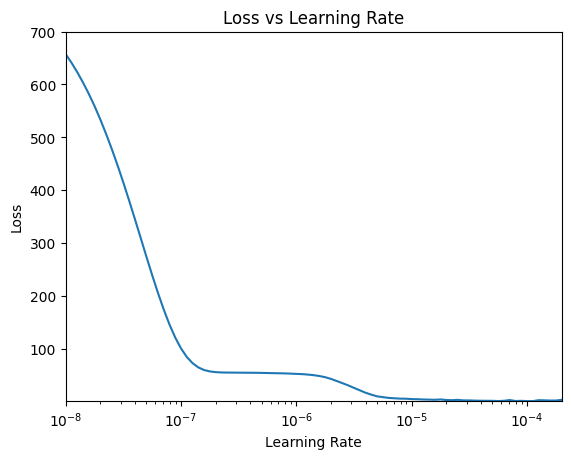

In [ ]:
# Plot learning rate v loss

import matplotlib.pyplot as plt

# Plot values
plt.semilogx(history.history['learning_rate'], history.history['loss'])
plt.axis([np.min(history.history['learning_rate']), np.max(history.history['learning_rate']), np.min(history.history['loss']), 700])

# Label plot
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Loss vs Learning Rate')

# Show plot
plt.show()

If the code is correct, you should see something similar to the following plot:


![__](https://biologicslab.co/BIO1173/images/class_06/class_06_1_image12.png)

As the `Loss` decreased during training, the `Learning Rate` sped up.

#### **Plot MAE vs Epoch**

The code in the cell below plot's the Mean Absolute Error (MAE) recorded during each epoch in the training. As you can see, the decrease in MAE was not a simple linear functtion, but showed different rates of change.

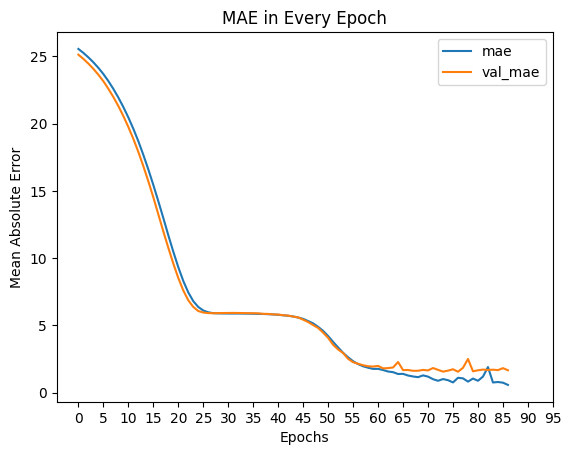

In [ ]:
# plot mae

import matplotlib.pyplot as plt

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['mae', 'val_mae'])
plt.xticks(np.arange(0,100, 5))

plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('MAE in Every Epoch')
plt.show()

If the code is correct, you should see the following table:


![__](https://biologicslab.co/BIO1173/images/class_06/class_06_1_image10.png)

#### **Plot 4 Frames with Label**

The code in the cell below generates a 2 X 2 plot showing 4 images from the dataset along with their lables/

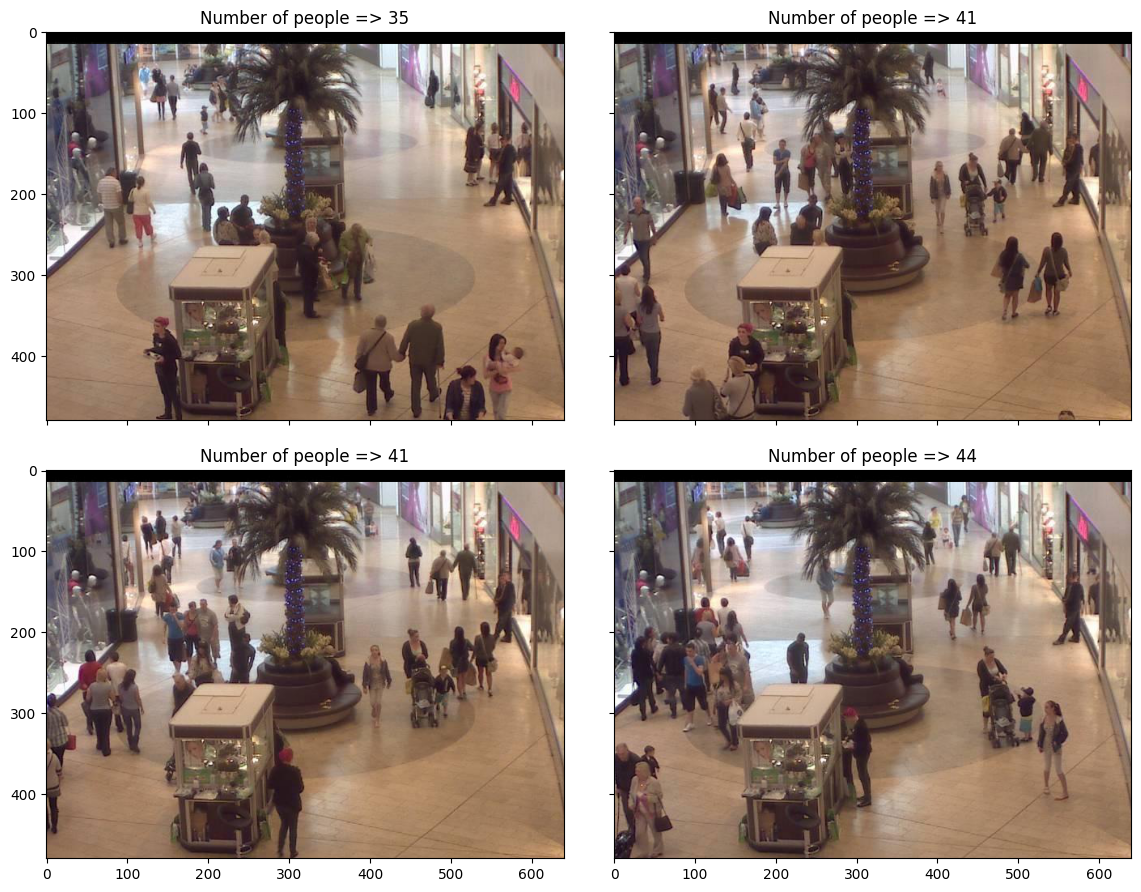

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


# Set figure size
fig = plt.figure(figsize=(14,14))
grid = ImageGrid(
        fig, 111,
        nrows_ncols=(2,2),
        axes_pad=0.5
)

# Plot 4 images
for x in range(0,4):
    grid[x].set_title('Number of people => ' + str(labels_ar[x]))
    grid[x].imshow(img_ar[x])


If the code is correct, you should see something similar to the following:


![__](https://biologicslab.co/BIO1173/images/class_06/class_06_1_image13.png)

The figure shows 4 pictures from a mall with the number of people in each image printed across the top.

# **Classification Neural Networks**

In this example, we will build a convolutional neural network (CNN) to analyze images of 3 different species of Iris flowers:
* iris-setosa
* iris-versicolour
* iris-virginica

In other words, this is an example of a **_classification_** CNN.

We have use the famous Iris flower dataset before.  However, when we use the Iris flower dataset previously, we used **_numeric measurements_** of the flower's sepals' and petals' lengths and widths, that were presented in tabular form (i.e. a DataFrame) in a CSV file.

In this lesson we will use hundreds of photographic images taken of Iris flowers from the three different species. Here is random example showing the the type of images in the dataset from each species:

![___](https://biologicslab.co/BIO1173/images/class_06/iris_species.png)

As above, we will setup an **_ImageDataGenerator_** to grab the images from a file location and feed them into our CNN along with their labels (species name).


### Setup Environmental Variables

The code in the section below sets ups ENVIRONMENTAL VARIABLES.


~~~text
DOWNLOAD_SOURCE https://biologicslab.co/BIO1173/data/paperclips.zip
DOWNLOAD_NAME paperclips.zip
EXTRACT_TARGET /content/clips
SOURCE /content/clips/paperclips

~~~

In [ ]:
# Setup Environmental Variables

import os

# Define datafile location
URL = "https://biologicslab.co/BIO1173/data"
DOWNLOAD_SOURCE = URL+"/OcularDisease.zip"
DOWNLOAD_NAME = DOWNLOAD_SOURCE[DOWNLOAD_SOURCE.rfind('/')+1:]
print(f"DOWNLOAD_SOURCE {DOWNLOAD_SOURCE}")
print(f"DOWNLOAD_NAME {DOWNLOAD_NAME}")

# Define folder locations to store the data
PATH = "/content"
EXTRACT_TARGET = os.path.join(PATH,"OcularDisease")
#SOURCE = os.path.join(EXTRACT_TARGET, "OcularDisease")
SOURCE = EXTRACT_TARGET # In this case its the same, no subfolder
print(f"PATH {PATH}")
print(f"EXTRACT_TARGET {EXTRACT_TARGET}")
print(f"SOURCE {SOURCE}")


DOWNLOAD_SOURCE https://biologicslab.co/BIO1173/data/OcularDisease.zip
DOWNLOAD_NAME OcularDisease.zip
PATH /content
EXTRACT_TARGET /content/OcularDisease
SOURCE /content/OcularDisease


If the code is correct, you should see the following output:

~~~text
DOWNLOAD_SOURCE https://biologicslab.co/BIO1173/data/OcularDisease.zip
DOWNLOAD_NAME OcularDisease.zip
PATH /content
EXTRACT_TARGET /content/OcularDisease
SOURCE /content/OcularDisease
~~~

## Download and Extract Images

Just as before, we will download a zip file containing the Iris images and then extract (unzip) the image data into the appropiate folders using the ENVIRONMENTAL VARIABLES defined above.


* `!unzip -o -d {EXTRACT_TARGET} {os.path.join(PATH, DOWNLOAD_NAME)}:` Unzips the file located at `os.path.join(PATH, DOWNLOAD_NAME)` into the directory specified by `EXTRACT_TARGET`. The `-o` flag forces overwriting of existing files without prompting.

* `>/dev/null`: Suppresses the output by redirecting it to /dev/null, so you don’t see the usual unzipping messages in the notebook.

* `!`: This tells the notebook to execute the following command in the shell.

* `wget`: The command-line utility for downloading files from the internet.

* `-o {os.path.join(PATH,DOWNLOAD_NAME)}`: This option specifies the output file path. It uses Python's os.path.join function to construct the full path where the file will be saved. PATH is the directory path, and DOWNLOAD_NAME is the name of the file. `/content/iris-image.zip`

* `{DOWNLOAD_SOURCE}:` This represents the URL of the file you want to download.DOWNLOAD_SOURCE https://biologicslab.co/BIO1173/data/iris-image.zip

In [ ]:
# Steo - 2: Download and Extract Data

# Download datafile
!wget -O {os.path.join(PATH,DOWNLOAD_NAME)} {DOWNLOAD_SOURCE}

# Make folders to store data
!mkdir -p {SOURCE}
!mkdir -p {TARGET}
!mkdir -p {EXTRACT_TARGET}

# Extract data into folders
!unzip -o -d {EXTRACT_TARGET} {os.path.join(PATH, DOWNLOAD_NAME)} >/dev/null


--2024-10-26 21:07:41--  https://biologicslab.co/BIO1173/data/OcularDisease.zip
Resolving biologicslab.co (biologicslab.co)... 194.163.45.209
Connecting to biologicslab.co (biologicslab.co)|194.163.45.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1742372148 (1.6G) [application/zip]
Saving to: ‘/content/OcularDisease.zip’

/content/OcularDise 100%[===================>]   1.62G  35.7MB/s    in 49s     

2024-10-26 21:08:31 (33.6 MB/s) - ‘/content/OcularDisease.zip’ saved [1742372148/1742372148]



If the code is correct, you should see something similar to the following output:

~~~text
--2024-10-26 12:59:20--  https://biologicslab.co/BIO1173/data/OcularDisease.zip
Resolving biologicslab.co (biologicslab.co)... 194.163.45.209
Connecting to biologicslab.co (biologicslab.co)|194.163.45.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1742372148 (1.6G) [application/zip]
Saving to: ‘/content/OcularDisease.zip’

/content/OcularDise 100%[===================>]   1.62G  33.8MB/s    in 51s     

2024-10-26 13:00:12 (32.3 MB/s) - ‘/content/OcularDisease.zip’ saved [1742372148/1742372148]]
~~~

In [ ]:
# Print out the files in current directory
files = os.listdir()
print(f"Current files {files}")

Current files ['.config', 'drive', 'OcularDisease.zip', 'OcularDisease', '{TARGET}', 'sample_data']


These lines are shell commands executed in a Google Colab notebook, used to create directories and unzip files. Here’s a detailed explanation:

1. **Create Directories:**

~~~text
!mkdir -p {SOURCE}
!mkdir -p {TARGET}
!mkdir -p {EXTRACT_TARGET}
~~~

* `!mkdir -p {SOURCE}:` Creates the directory specified by SOURCE. The -p option ensures that no error is thrown if the directory already exists and also creates any necessary parent directories.

* `!mkdir -p {TARGET}:` Similarly, creates the directory specified by TARGET.

* `!mkdir -p {EXTRACT_TARGET}:` Creates the directory specified by EXTRACT_TARGET.

2. **Unzip File:**

~~~text
!unzip -o -d {EXTRACT_TARGET} {os.path.join(PATH, DOWNLOAD_NAME)} >/dev/null
~~~

* `!unzip -o -d {EXTRACT_TARGET} {os.path.join(PATH, DOWNLOAD_NAME)}:` Unzips the file located at os.path.join(PATH, DOWNLOAD_NAME) into the directory specified by EXTRACT_TARGET. The -o flag forces overwriting of existing files without prompting.

* `>/dev/null:` Suppresses the output by redirecting it to `/dev/null`, so you don’t see the usual unzipping messages in the notebook.

In essence, this sequence of commands ensures that the necessary directories exist and extracts a downloaded file into a specified directory, keeping the notebook output clean and tidy. Practical and neat!

### Create **ImageDataGenerator** with `flow_from_directory`

In the cell below, we set up the generator as before.  However, this time we use `flow_from_directory` to get the labels from the directory structure using this code chunk:
~~~text
validation_generator = validation_datagen.flow_from_directory(
    directory=DATA_FOLDER, target_size=(256, 256),
    class_mode='categorical', batch_size=32, shuffle=True)
~~~


In [ ]:
!pip install keras.preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00


In [ ]:
# Create ImageDataGenerator with flow from directory

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import tensorflow as tf
#import keras_preprocessing
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(
  rescale = 1./255,
  horizontal_flip=True,
  vertical_flip=True,
  width_shift_range=[-200,200],
  rotation_range=360,
  fill_mode='nearest')

train_generator = training_datagen.flow_from_directory(
    directory=SOURCE, target_size=(256, 256),
    class_mode='categorical', batch_size=32, shuffle=True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
    directory=SOURCE,
    target_size=(256, 256),
    class_mode='categorical', batch_size=32, shuffle=True)


Found 14392 images belonging to 2 classes.
Found 14392 images belonging to 2 classes.


If your code is correct you should see the following output:
~~~text
Found 14392 images belonging to 3 classes.
Found 14392 images belonging to 3 classes.
~~~

### Construct, compile and train CNN

The CNN neural network for image classification is similar to the one constructed above for regression. One important difference, as you should expect, is that instead of the output layer containing only one neuron for regression, our classification CNN needs a separate output neuron for each output class. To figure out the number of output classess, we use the following code chunk to create a variable called `class_count`:
~~~text
# Compute the number of classes for output layer
class_count = len(train_generator.class_indices)
~~~
We then use the variable `class_count` to add the correct number of neurons to the output layer:
~~~text
# Output layer has 3 neurons, one for each class
tf.keras.layers.Dense(class_count, activation='softmax')
~~~

The code below sets the variable `EPOCHS=50`. If your computer is really slow, you could reduce this value to 25.


In [ ]:
# Step

import pandas as pd
import numpy as np
import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten

# Define variables
input_dim = (256,256,3)

# Determine the number of classes
class_count = len(train_generator.class_indices)

# Create CNN model
model = keras.Sequential([

    # Input Layer
    keras.layers.Input(shape=input_dim),

    # 1st Convolution layer
    keras.layers.Conv2D(16, (3,3),
          activation=keras.activations.relu),
    keras.layers.MaxPool2D(2,2),

    # 2nd Convolution layer
    keras.layers.Conv2D(32, (3,3),
          activation=keras.activations.relu),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.5),

    # 3rd Convolution layer
    keras.layers.Conv2D(64, (3,3),
          activation=keras.activations.relu),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.5),

    # 4th Convolution layer
    keras.layers.Conv2D(64, (3,3),
          activation=keras.activations.relu),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.5),

    # 5th Convolution layer
    keras.layers.Conv2D(64, (3,3),
          activation=keras.activations.relu),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.5),

    # Flatten the results to feed into a DNN
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),

    # 512 neuron hidden layer
    keras.layers.Dense(512,
          activation=keras.activations.relu),

     # Output layer has neurons equal to class_count
    keras.layers.Dense(class_count,
          activation = keras.activations.softmax)

])

#model.compile(loss='categorical_crossentropy', optimizer='adam')
# Compile model
model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=1e-5), metrics=['mae'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,278,626 (4.88 MB)

 Trainable params: 1,278,626 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

~~~text
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 dropout_6 (Dropout)         (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 dropout_7 (Dropout)         (None, 60, 60, 64)        0         
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 2304)              0         
                                                                 
 dropout_8 (Dropout)         (None, 2304)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1180160   
                                                                 
 dense_13 (Dense)            (None, 3)                 1539      
                                                                 
=================================================================
Total params: 1279139 (4.88 MB)
Trainable params: 1279139 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

~~~

In [ ]:
# Step - 8: Create callback monitors

from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler


# Create learning rate monitor
l_rate_monitor = keras.callbacks.LearningRateScheduler(lambda epochs : 1e-8 * 10 ** (epochs/20))

# Create early stoppin monitor
e_stop_monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10,
                 verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
# Step - 8: Train the Model -- This will take at least 45 minutes!

import time

# Set variables
EPOCHS=100
BATCH_SIZE=256   #128
STEPS_PER_EPOCH=57     #113

# Record start time
start_time = time.time()

# Print header
# Print header
print(f"----- Training is starting for {EPOCHS} epochs, batch size:{BATCH_SIZE}, step size:{STEPS_PER_EPOCH}, runtime GPU/TPU:{my_GPU} --------------")

# Train the model
history = model.fit(train_generator,
          epochs=EPOCHS,
          steps_per_epoch=STEPS_PER_EPOCH,
          batch_size=BATCH_SIZE,
          validation_data = validation_generator,
          callbacks=[e_stop_monitor, l_rate_monitor])

# Record end time
elapsed_time = time.time() - start_time

# Print elapsed time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

----- Training is starting for 100 epochs, batch size:256, step size:57, runtime GPU/TPU:A100 --------------
Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step - loss: 0.7353 - mae: 0.5100 - val_loss: 0.6909 - val_mae: 0.4981 - learning_rate: 1.0000e-08
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 213s 4s/step - loss: 0.7323 - mae: 0.5072 - val_loss: 0.6909 - val_mae: 0.4981 - learning_rate: 1.1220e-08
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - loss: 0.7231 - mae: 0.5032 - val_loss: 0.6909 - val_mae: 0.4981 - learning_rate: 1.2589e-08
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - loss: 0.7346 - mae: 0.5084 - val_loss: 0.6909 - val_mae: 0.4981 - learning_rate: 1.4125e-08
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - loss: 0.7349 - mae: 0.5103 - val_loss: 0.6909 - val_mae: 0.4981 - learning_rate: 1.5849e-08
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - loss: 0.7396 - mae: 0.5102 - val_loss: 0.6909 - val_mae: 0.4981 - learning_rate: 1.7783e-08
Epoch 7/100
57/

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


57/57 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - loss: 0.7312 - mae: 0.5079 - val_loss: 0.6909 - val_mae: 0.4982 - learning_rate: 2.2387e-08
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step - loss: 0.7346 - mae: 0.5094 - val_loss: 0.6910 - val_mae: 0.4982 - learning_rate: 2.5119e-08
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step - loss: 0.7417 - mae: 0.5116 - val_loss: 0.6910 - val_mae: 0.4982 - learning_rate: 2.8184e-08
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
Elapsed time: 0:33:35.79


If the code is correct, you should see something similar to the following output:

~~~text
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 125, 125, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
 Total params: 1,278,626 (4.88 MB)
 Trainable params: 1,278,626 (4.88 MB)
 Non-trainable params: 0 (0.00 B)
Starting training for 50 epochs...
Epoch 1/50
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
10/10 ━━━━━━━━━━━━━━━━━━━━ 202s 20s/step - loss: 0.6606 - val_loss: 0.8725
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 210s 23s/step - loss: 0.4386 - val_loss: 0.6827
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 167s 18s/step - loss: 0.3167 - val_loss: 0.5802
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 164s 18s/step - loss: 0.4401 - val_loss: 0.5913
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 166s 18s/step - loss: 0.3439 - val_loss: 0.5346
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 208s 23s/step - loss: 0.3399 - val_loss: 0.5666
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 167s 19s/step - loss: 0.3394 - val_loss: 0.5653
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 164s 18s/step - loss: 0.2753 - val_loss: 0.5584
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 171s 19s/step - loss: 0.2865 - val_loss: 0.5652
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 172s 19s/step - loss: 0.3872 - val_loss: 0.5856
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
Elapsed time: 0:29:51.99
~~~

In [ ]:
#

# Train model with EarlyStopping
print(f"Starting training for {EPOCHS} epochs...")
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Now use val_generator in the model.fit() call
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_generator,
    callbacks=[monitor],
    verbose=1)

#history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_generator, callbacks=[monitor], verbose=1)

# Print elapsed time
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


In [ ]:
from keras.models import save_model
import os

# Save the model in the native Keras format
model.save('ocular_disease_model.keras')



In [ ]:
from google.colab import files
#files.download('path_to_your_file')
files.download('ocular_disease_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

On my Windows machine, 50 epochs required between 2-4 minutes.

### Compute Accuracy Score

As before, we use **_RMSE_** to compute the accuracy of a regression analysis, and the **_Accuracy Score_** to compute the accuracy of a classification analysis.

The code in the cell below, computes the Accuracy Score for our classification CNN.

In [ ]:
# Compute accuracy score

from sklearn.metrics import accuracy_score
import numpy as np

validation_generator.reset()
pred = model.predict(validation_generator)

predict_classes = np.argmax(pred,axis=1)
expected_classes = validation_generator.classes

correct = accuracy_score(expected_classes,predict_classes)
print(f"Accuracy: {correct}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


450/450 ━━━━━━━━━━━━━━━━━━━━ 164s 360ms/step
Accuracy: 0.5138271261812117


If your code is correct you should see something similar to the following output:
~~~text

450/450 ━━━━━━━━━━━━━━━━━━━━ 164s 360ms/step
Accuracy: 0.5138271261812117
~~~
Whereas we previously built a deep neural network able predict the Iris species with near 100% accuracy using the sepal and petal measurements, predicting a flower's species from its image is more difficult. Our CNN was only able to obtain ~64% accuracy rate.



# Other Resources

* [Imagenet:Large Scale Visual Recognition Challenge 2014](http://image-net.org/challenges/LSVRC/2014/index)
* [Andrej Karpathy](http://cs.stanford.edu/people/karpathy/) - PhD student/instructor at Stanford.
* [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/) - Stanford course on computer vision/CNN's.
* [CS231n - GitHub](http://cs231n.github.io/)
* [ConvNetJS](http://cs.stanford.edu/people/karpathy/convnetjs/) - JavaScript library for deep learning.

## **Lesson Turn-in**

When you have completed and run all of the code cells, use the **File --> Print.. --> Save to PDF** to generate a PDF of your Colab notebook. Save your PDF as `Class_06_1.lastname.pdf` where _lastname_ is your last name, and upload the file to Canvas.